<a href="https://colab.research.google.com/github/bw123111/csci547_ML/blob/main/examples/lasso_collinearity_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LASSO vs Collinearity: A Hands‑On Demo

**Goal:** Show that with two highly collinear predictors, LASSO will often set one coefficient to exactly 0 (and which one gets dropped can flip with tiny data changes), while Ridge shrinks but typically keeps both nonzero.

**What you'll do:**
1. Generate synthetic data where `X2 ≈ X1` (strong collinearity) and the target is `y = 3·X1 + 2·X3 + noise`. (I'll provide you some code).
2. Fit LASSO across a range of α values and pick a sparse solution with exactly two non‑zero coefficients.
3. Plot the LASSO coefficient paths vs `log10(alpha)` to visualize when coefficients enter/leave the model.
4. Compare to Ridge (no exact zeros).
5. Repeat the experiment across many random seeds to **demonstrate arbitrariness** in which collinear feature survives.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile, ZIP_DEFLATED
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, lasso_path

plt.rcParams.update({"figure.dpi": 144})

## 1) Generate a dataset with two highly collinear features
Here I've made `X2 = X1 + ε` where `ε ~ N(0, σ²)` with a **small** σ to induce strong collinearity.

TO DO: Plot the correlations of the features as a heatmap.  

In [2]:
# Parameters you can tweak
SEED = 42
N = 300
COLLINEAR_NOISE = 0.02   # smaller -> stronger collinearity between X1 and X2
Y_NOISE = 1.0

rng = np.random.default_rng(SEED)
X1 = rng.normal(size=N)
X2 = X1 + rng.normal(scale=COLLINEAR_NOISE, size=N)
X3 = rng.normal(size=N)
y  = 3.0*X1 + 2.0*X3 + rng.normal(scale=Y_NOISE, size=N)

df = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3, "y": y})

print("\nCorrelation among predictors (expect X1≈X2):")
display(df[["X1","X2","X3"]].corr())


Correlation among predictors (expect X1≈X2):


,X1,X2,X3
X1,1.000000,0.999762,-0.072945
X2,0.999762,1.000000,-0.075797
X3,-0.072945,-0.075797,1.000000


<Axes: >

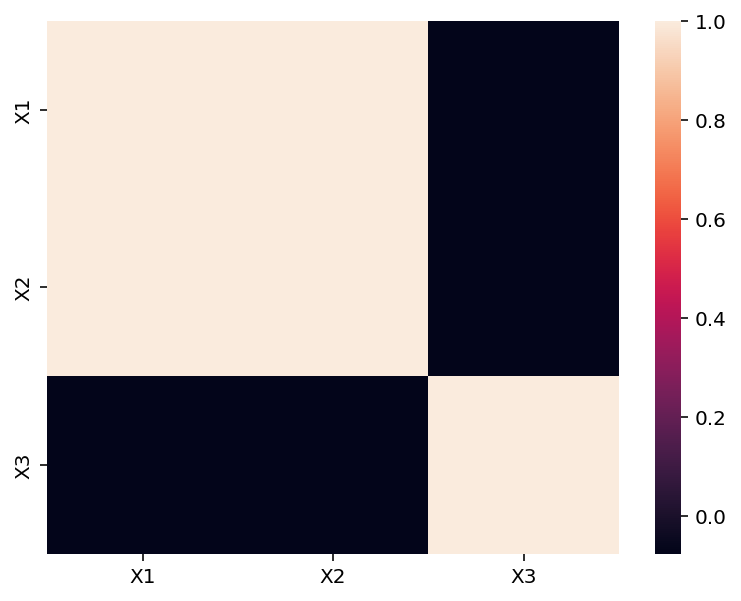

In [15]:
### Heatmap here

import seaborn as sns

sns.heatmap(df[['X1', 'X2', 'X3']].corr(),
            )

## 2) LASSO sweep over α to find a model with exactly 2 non‑zero coefficients
Ok! Here I have some sample code using one value of α and extracting the feature coefficients.  

TO DO: Now let's sweep over different values of α.  Try using [.00001, .0001, .001, .01, .1, 1] to start, and the goal of the search is trying to find an α with exactly two non‑zero coefficients (ideally `X3` plus one of `X1` or `X2`).
What value of α do you get?

In [19]:
X = df[["X1","X2","X3"]].values
y_arr = df["y"].values

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=.001, fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0))
])

pipe.fit(X, y_arr)
coefs = pipe.named_steps["lasso"].coef_
print(coefs)

[ 3.22749009 -0.41467568  2.05242318]


In [32]:
### Your turn!
alphas = [.00001, .0001, .001, .01, .1, 1]
for i in range(0, len(alphas)):
  pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=alphas[i], fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0))
  ])

  pipe.fit(X, y_arr)
  coefs = pipe.named_steps["lasso"].coef_
  print(f"alpha = {alphas[i]}  coefs: {coefs}\n")


alpha = 1e-05  coefs: [ 7.45486182 -4.64287364  2.0412953 ]

alpha = 0.0001  coefs: [ 7.07056109 -4.25849779  2.04230691]

alpha = 0.001  coefs: [ 3.22749009 -0.41467568  2.05242318]

alpha = 0.01  coefs: [2.80329543 0.         2.04391135]

alpha = 0.1  coefs: [2.7062138  0.         1.94682972]

alpha = 1  coefs: [1.73539744 0.         0.97601337]



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.732e-02, tolerance: 3.676e-03
  model = cd_fast.enet_coordinate_descent(


## 3) LASSO coefficient paths
TO DO: Track (plot) how each coefficient changes along the regularization path. With `X1` and `X2` collinear, one of them will typically be driven to **exactly zero** for sufficiently large α.

Hint: You can use the same alpha values: [.000001, .00001, .0001, .001, .01, .1, 1] but the plot will be much neater if you use `plt.xscale('log')`.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.732e-02, tolerance: 3.676e-03
  model = cd_fast.enet_coordinate_descent(


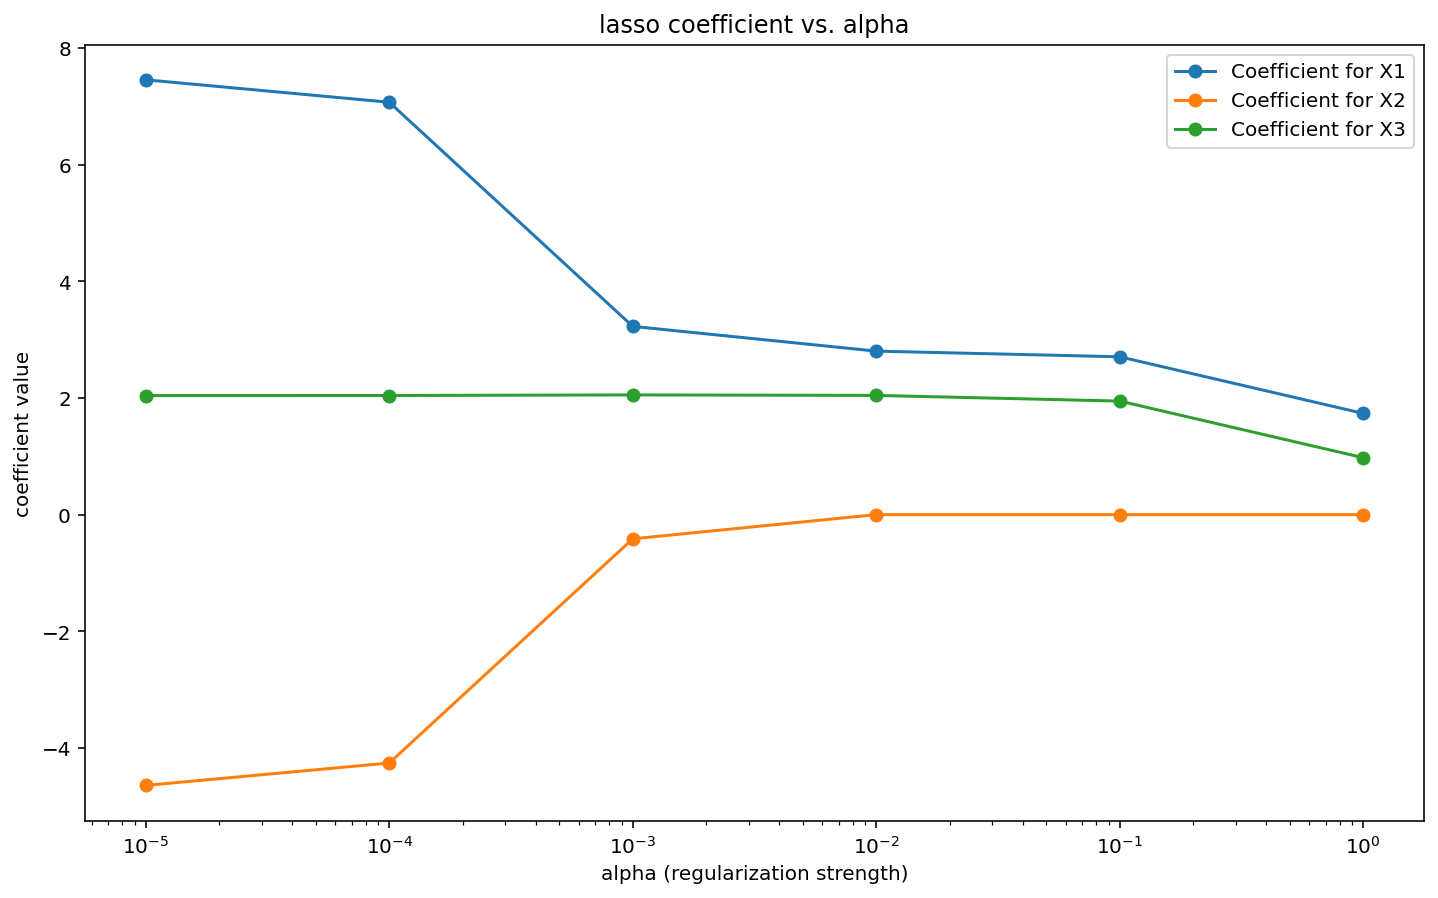

In [33]:
### Plot coefficients across alphas
coefs_list = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0)
    lasso.fit(X_scaled, y_arr)
    coefs_list.append(lasso.coef_)

plt.figure(figsize=(12, 7))
for i in range(len(coefs_list[0])):
    plt.plot(alphas, [coef[i] for coef in coefs_list], marker='o', linestyle='-', label=f'Coefficient for X{i+1}')

plt.xscale('log')
plt.xlabel('alpha (regularization strength)')
plt.ylabel('coefficient value')
plt.title('lasso coefficient vs. alpha')
plt.legend()
plt.show()

## 4) Ridge comparison
TO DO: Complare these coefficients to Ridge.  Remember, Ridge regularization (L2) shrinks coefficients but rarely sets them to **exactly** zero, even with strong collinearity.

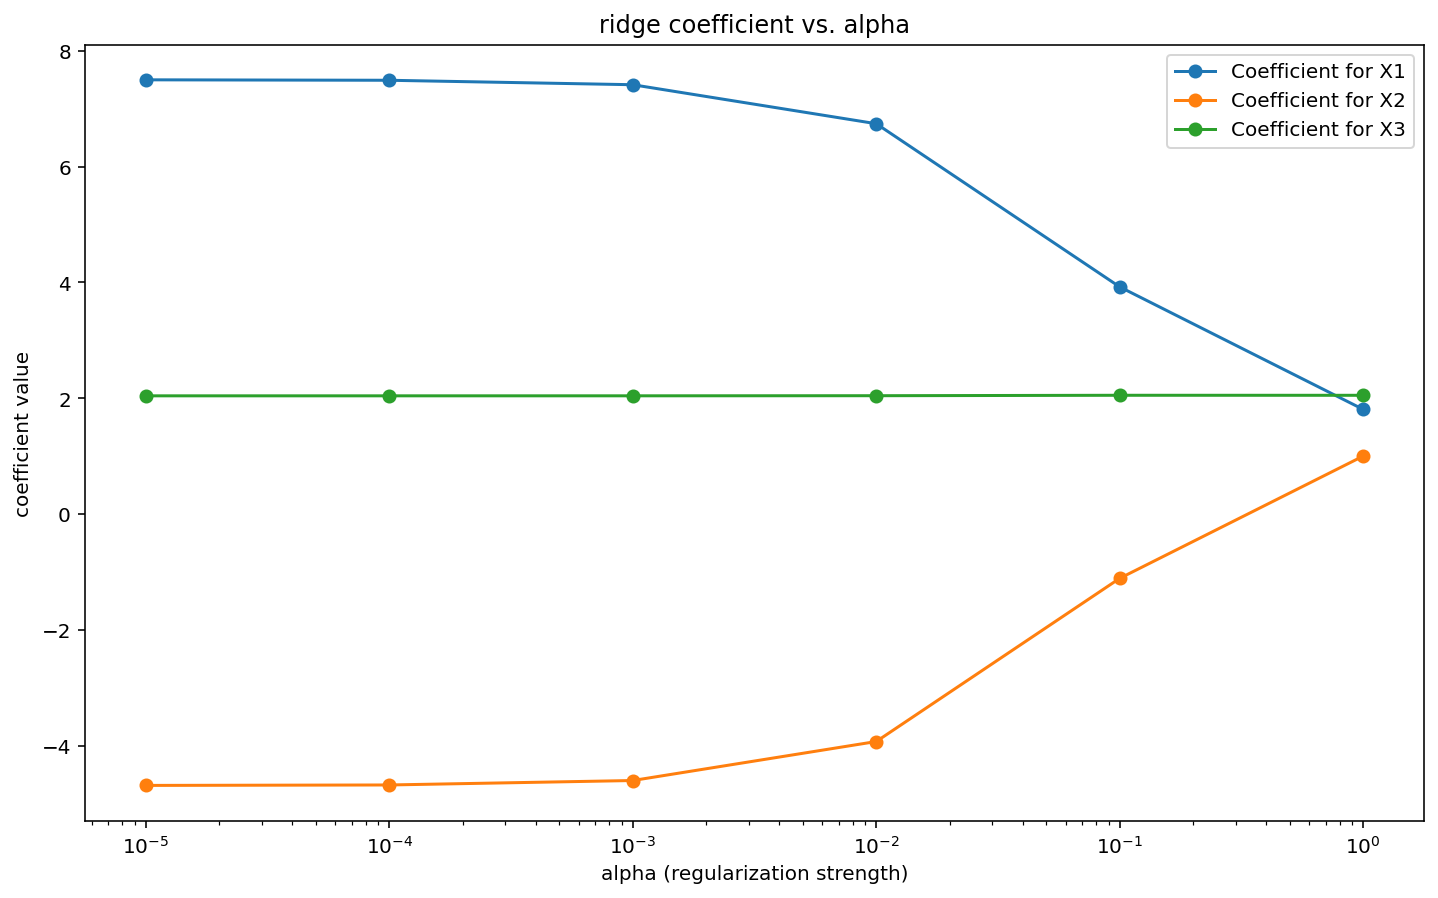

In [34]:
### What's the output using Ridge?
### Plot coefficients across alphas
ridge_coefs_list = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0)
    ridge.fit(X_scaled, y_arr)
    ridge_coefs_list.append(ridge.coef_)

plt.figure(figsize=(12, 7))
for i in range(len(ridge_coefs_list[0])):
    plt.plot(alphas, [coef[i] for coef in ridge_coefs_list], marker='o', linestyle='-', label=f'Coefficient for X{i+1}')

plt.xscale('log')
plt.xlabel('alpha (regularization strength)')
plt.ylabel('coefficient value')
plt.title('ridge coefficient vs. alpha')
plt.legend()
plt.show()

## 5) Repeat across many seeds to show arbitrariness
Ok now we get to the big thing!  Let's regenerate the dataset with different random seeds and fit a LASSO model for each. We then count how often `X1` survives vs `X2` (or both/neither). Plot correlations between the features as a heatmap and plot the alpha path. Go for it!

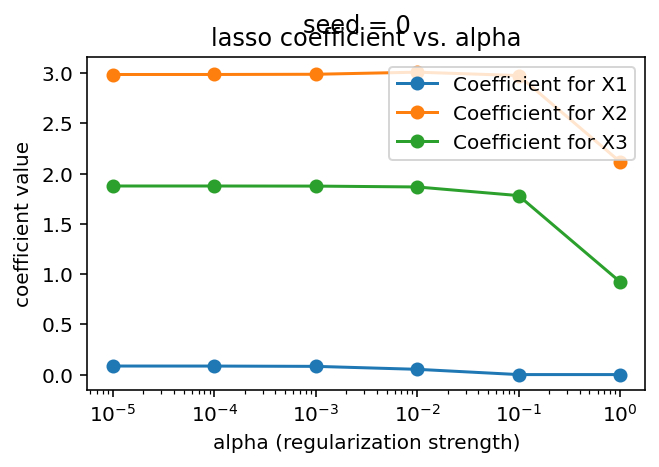

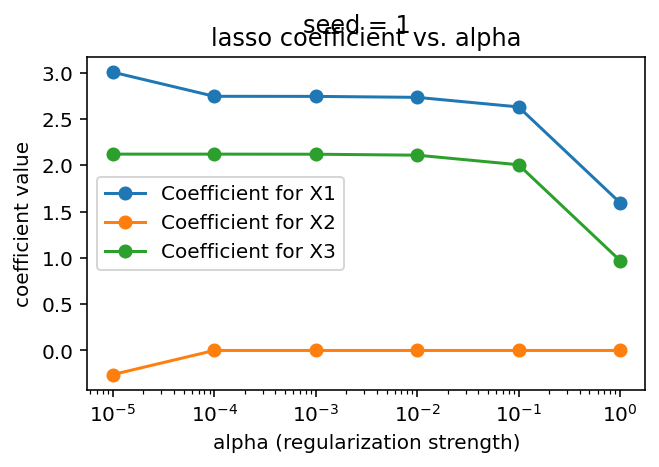

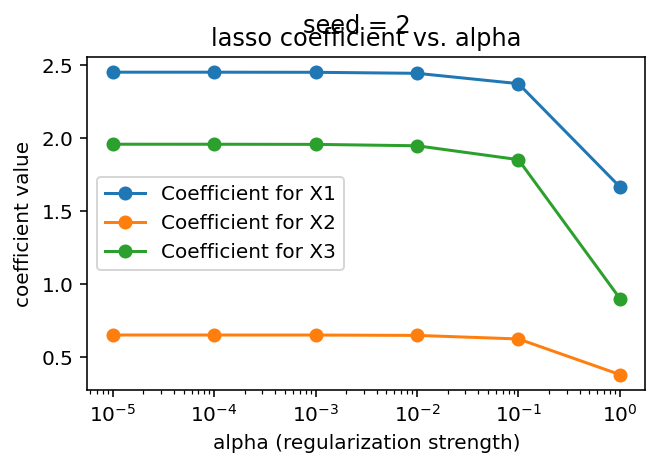

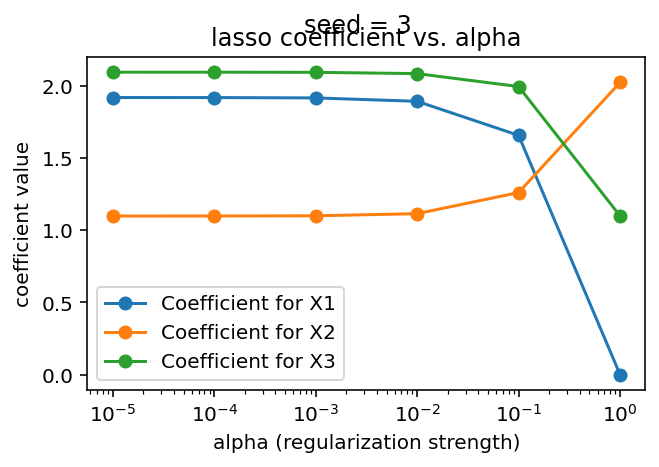

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.875e-02, tolerance: 4.841e-03
  model = cd_fast.enet_coordinate_descent(


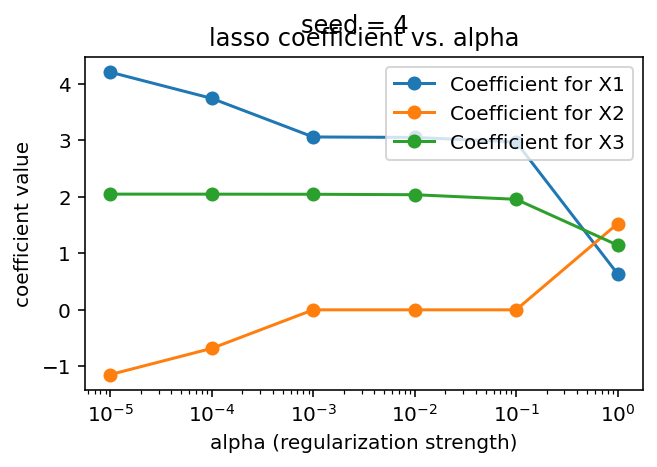

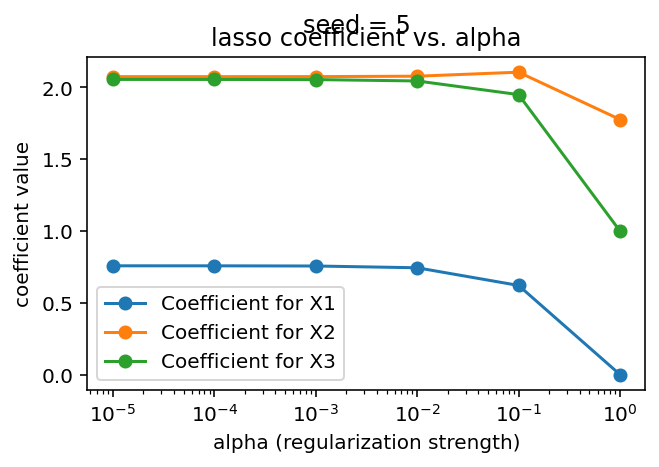

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-02, tolerance: 4.238e-03
  model = cd_fast.enet_coordinate_descent(


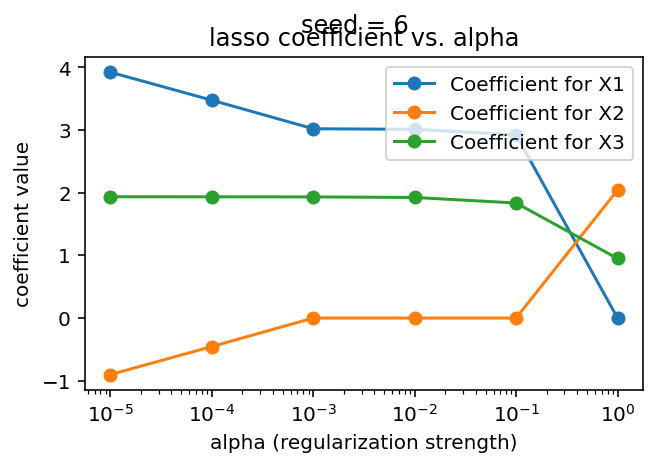

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.873e-01, tolerance: 3.548e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.928e-03, tolerance: 3.548e-03
  model = cd_fast.enet_coordinate_descent(


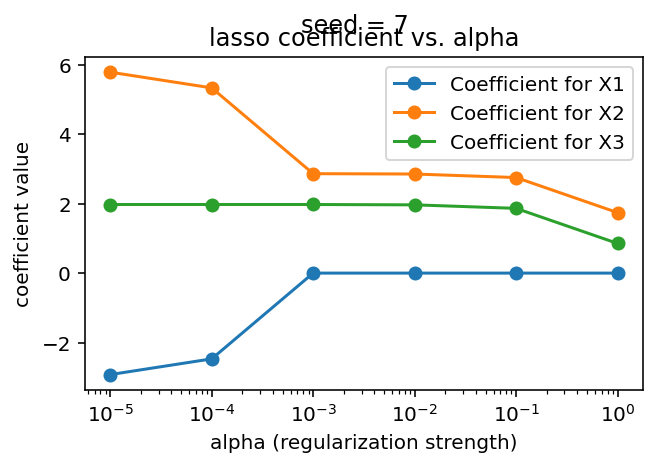

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+00, tolerance: 4.582e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e-02, tolerance: 4.582e-03
  model = cd_fast.enet_coordinate_descent(


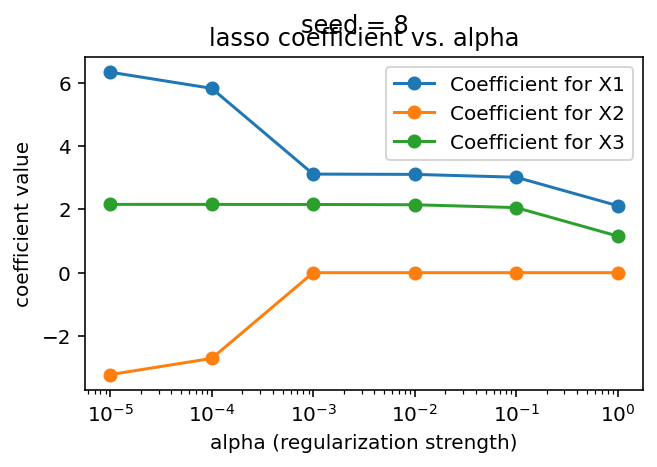

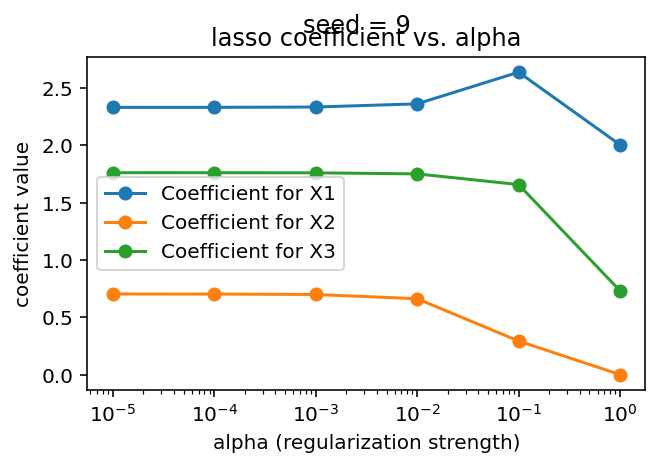

In [42]:
N_SEEDS = 10
records = []
for seed in range(N_SEEDS):
    ### You got this!!
    rng = np.random.default_rng(seed=seed)
    X1 = rng.normal(size=N)
    X2 = X1 + rng.normal(scale=COLLINEAR_NOISE, size=N)
    X3 = rng.normal(size=N)
    y  = 3.0*X1 + 2.0*X3 + rng.normal(scale=Y_NOISE, size=N)

    df = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3, "y": y})

    X = df[["X1","X2","X3"]].values
    y_arr = df["y"].values

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=.001, fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0))
    ])

    pipe.fit(X, y_arr)

    coefs_list = []
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for alpha in alphas:
        lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=20000, tol=1e-6, random_state=0)
        lasso.fit(X_scaled, y_arr)
        coefs_list.append(lasso.coef_)

    plt.figure(figsize=(5,3))
    fig, ax
    for i in range(len(coefs_list[0])):
        plt.plot(alphas, [coef[i] for coef in coefs_list], marker='o', linestyle='-', label=f'Coefficient for X{i+1}')

    plt.xscale('log')
    plt.xlabel('alpha (regularization strength)')
    plt.ylabel('coefficient value')
    plt.title('lasso coefficient vs. alpha')
    plt.suptitle(f"seed = {seed}")
    plt.legend()
    plt.show()



## 6) Bonus! Elastic Net: bridging LASSO and Ridge

Elastic Net combines L1 and L2 penalties. The mixing parameter `l1_ratio` controls the blend:
- `l1_ratio = 1` → pure **LASSO** (L1)
- `l1_ratio = 0` → pure **Ridge** (L2)

With highly collinear features, Elastic Net often shows a **grouping effect**: correlated predictors tend to be selected together more readily than with pure LASSO. Below, try to (a) pick `alpha` and `l1_ratio` using cross‑validation, (b) visualize Elastic Net coefficient paths for a few `l1_ratio` values, and (c) compare CV‑selected coefficients for Ridge, LASSO, and Elastic Net.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+02, tolerance: 4.346e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+02, tolerance: 4.346e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.896e-01, tolerance: 4.346e

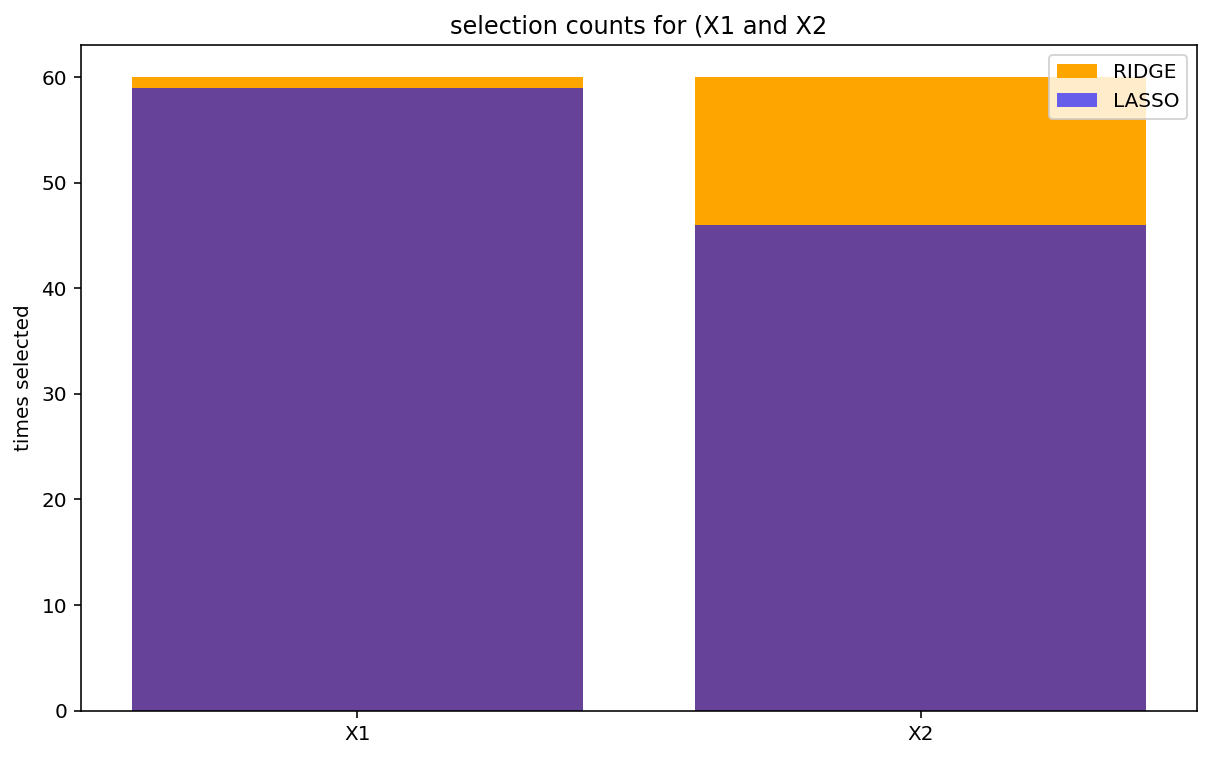

In [40]:
### Try using elastic net and see what happens!
N_SEEDS = 10
l_records = []
r_records = []
for seed in range(N_SEEDS):

    rng = np.random.default_rng(seed)
    X1 = rng.normal(size=N)
    X2 = X1 + rng.normal(scale=COLLINEAR_NOISE, size=N)
    X3 = rng.normal(size=N)
    y  = 3.0*X1 + 2.0*X3 + rng.normal(scale=Y_NOISE, size=N)

    X = np.column_stack([X1, X2, X3])

    for alpha in alphas:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("lasso", Lasso(alpha=alpha, fit_intercept=True, random_state=seed))
        ])
        pipe.fit(X, y)
        coefs = pipe.named_steps["lasso"].coef_

        l_records.append({
            "alpha": alpha,
            "seed": seed,
            "coef_X1": coefs[0],
            "coef_X2": coefs[1],
            "coef_X3": coefs[2],
            "X1_survived": abs(coefs[0]) > 1e-6,
            "X2_survived": abs(coefs[1]) > 1e-6,
        })

    for alpha in alphas:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha, fit_intercept=True, random_state=seed))
        ])
        pipe.fit(X, y)
        coefs = pipe.named_steps["ridge"].coef_

        r_records.append({
            "alpha": alpha,
            "seed": seed,
            "coef_X1": coefs[0],
            "coef_X2": coefs[1],
            "coef_X3": coefs[2],
            "X1_survived": abs(coefs[0]) > 1e-6,
            "X2_survived": abs(coefs[1]) > 1e-6,
        })


lasso_results_df = pd.DataFrame(l_records)
lasso_survival_counts = lasso_results_df[['X1_survived', 'X2_survived']].sum()

ridge_results_df = pd.DataFrame(r_records)
ridge_survival_counts = ridge_results_df[['X1_survived', 'X2_survived']].sum()

plt.figure(figsize=(10, 6))
plt.bar(['X1', 'X2'], ridge_survival_counts, label='RIDGE', color='orange')
plt.bar(['X1', 'X2'], lasso_survival_counts, alpha=0.6, label='LASSO', color='blue')
plt.ylabel('times selected')
plt.title('selection counts for (X1 and X2')
plt.legend()
plt.show()

## Discussion
- **LASSO (L1)** promotes sparsity by adding an \(L_1\) penalty; under strong collinearity, multiple solutions give similar fit quality, so the penalty can **select one feature and zero out its twin**. Tiny data changes can flip which one survives.
- **Ridge (L2)** shares weight across collinear features—**shrinks** them but rarely makes them **exactly 0**.
- The path plot connects this intuition visually: as α increases, one of the collinear coefficients is pushed to 0 while the other remains.
- **Knobs to turn:**
  - Increase/decrease `COLLINEAR_NOISE` to strengthen/relax collinearity.
  - Try different α ranges or selection rules.
  - Add more redundant predictors to show LASSO picking a subset.
